<a href="https://colab.research.google.com/github/TechDailyNotes/study-notes-triton/blob/main/triton_01_vector_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Addition

## Compute Kernel

In [2]:
import torch
import triton
import triton.language as tl

@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
  # Step 0: Get device hyperparameters.
  pid = tl.program_id(axis=0)
  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE)
  mask = offsets < n_elements

  # Step 1: Load elements.
  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)

  # Step 2: Compute output.
  output = x + y

  # Step 3: Store output.
  tl.store(output_ptr + offsets, output, mask=mask)

In [5]:
def add(x: torch.Tensor, y: torch.Tensor):
  # Step 1: Init output.
  output = torch.empty_like(x)
  assert x.is_cuda and y.is_cuda and output.is_cuda

  # Step 2: Get kernel parameters.
  n_elements = output.numel()
  grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]), )

  # Step 3: Launch kernel function.
  add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

  # Step 4: Return output.
  return output

In [7]:
torch.manual_seed(0)
size = 98432

x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")

output_torch = x + y
output_triton = add(x, y)

print(output_torch)
print(output_triton)
print(
  f"Maximum difference between results is "
  f"{torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
Maximum difference between results is 0.0


## Benchmark

In [13]:
@triton.testing.perf_report(
  triton.testing.Benchmark(
    x_names=["size"], x_vals=[2 ** i for i in range(12, 28, 1)], x_log=True,
    line_arg="provider", line_vals=["triton", "torch"],
    line_names=["Triton", "Torch"], styles=[("blue", "-"), ("green", "-")],
    ylabel="GB/s", plot_name="Vector Add Performance", args={},
  )
)
def benchmark(size, provider):
  # Step 1: Init inputs.
  x = torch.rand(size, dtype=torch.float32, device="cuda")
  y = torch.rand(size, dtype=torch.float32, device="cuda")

  # Step 2: Set benchmark parameters.
  quantiles = [0.5, 0.2, 0.8]

  # Step 3: Launch benchmarking.
  if provider == "torch":
    ms, min_ms, max_ms = triton.testing.do_bench(
      lambda: x + y, quantiles=quantiles,
    )
  if provider == "triton":
    ms, min_ms, max_ms = triton.testing.do_bench(
      lambda: add(x, y), quantiles=quantiles,
    )

  # Step 4: Compute throughput.
  gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
  return gbps(ms), gbps(min_ms), gbps(max_ms)

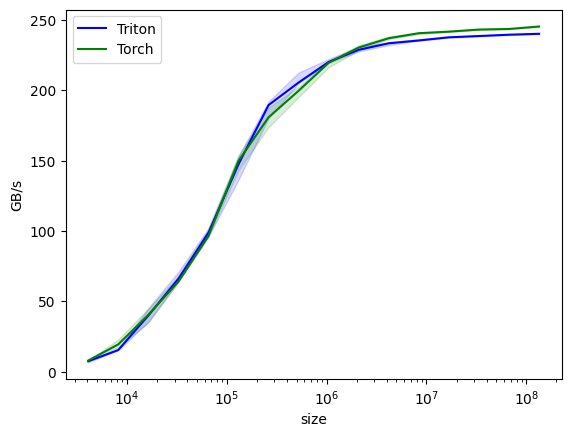

Vector Add Performance:
           size      Triton       Torch
0        4096.0    7.474453    7.958549
1        8192.0   15.437186   19.443039
2       16384.0   39.896105   40.421054
3       32768.0   66.064514   63.999998
4       65536.0   98.698793   96.376474
5      131072.0  147.382306  149.853661
6      262144.0  189.410407  180.705879
7      524288.0  205.442004  199.602020
8     1048576.0  220.042531  219.428568
9     2097152.0  228.680423  230.287560
10    4194304.0  233.310688  236.912787
11    8388608.0  235.317769  240.462307
12   16777216.0  237.547897  241.570266
13   33554432.0  238.461761  243.054116
14   67108864.0  239.402060  243.477406
15  134217728.0  240.048318  245.221190


In [14]:
benchmark.run(show_plots=True, print_data=True)

# Practice

## Compute Kernel

In [19]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, num_elements, BLOCK_SIZE: tl.constexpr):
  # Step 1: Get device parameters.
  pid = tl.program_id(axis=0)
  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE)
  mask = offsets < num_elements

  # Step 2: Load data.
  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)

  # Step 3: Compute output.
  output = x + y

  # Step 4: Store data.
  tl.store(output_ptr + offsets, output, mask=mask)

In [20]:
def add(x: torch.Tensor, y: torch.Tensor):
  # Step 1: Init output.
  output = torch.empty_like(x)

  # Step 2: Set kernel parameters.
  num_elements = x.numel()
  grid = lambda meta: (triton.cdiv(num_elements, meta["BLOCK_SIZE"]), )

  # Step 3: Launch kernel function.
  add_kernel[grid](x, y, output, num_elements, BLOCK_SIZE=1024)

  # Step 4: Return output.
  return output

In [26]:
torch.manual_seed(0)
size = 98432

x = torch.rand(size, dtype=torch.float32, device="cuda")
y = torch.rand(size, dtype=torch.float32, device="cuda")

output_torch = x + y
output_triton = add(x, y)

print(output_torch)
print(output_triton)
print(f"Max diff is {torch.max(torch.abs(output_torch - output_triton))}.")

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
Max diff is 0.0.


## Benchmark

In [27]:
@triton.testing.perf_report(
  triton.testing.Benchmark(
    x_names=["size"], x_vals=[2 ** i for i in range(12, 28, 1)], x_log=True,
    line_arg="provider", line_vals=["triton", "torch"],
    line_names=["Triton", "Torch"], styles=[("blue", "-"), ("green", "-")],
    ylabel="GB/s", plot_name="Vector Add Performance", args={},
  )
)
def benchmark(size, provider):
  # Step 1: Init inputs.
  x = torch.rand(size, dtype=torch.float32, device="cuda")
  y = torch.rand(size, dtype=torch.float32, device="cuda")

  # Step 2: Set benchmark parameters.
  quantiles = [0.5, 0.2, 0.8]

  # Step 3: Launch benchmark.
  if provider == "triton":
    ms, min_ms, max_ms = triton.testing.do_bench(
      lambda: add(x, y), quantiles=quantiles,
    )
  if provider == "torch":
    ms, min_ms, max_ms = triton.testing.do_bench(
      lambda: x + y, quantiles=quantiles,
    )

  # Step 4: Compute throughput.
  gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
  return gbps(ms), gbps(min_ms), gbps(max_ms)

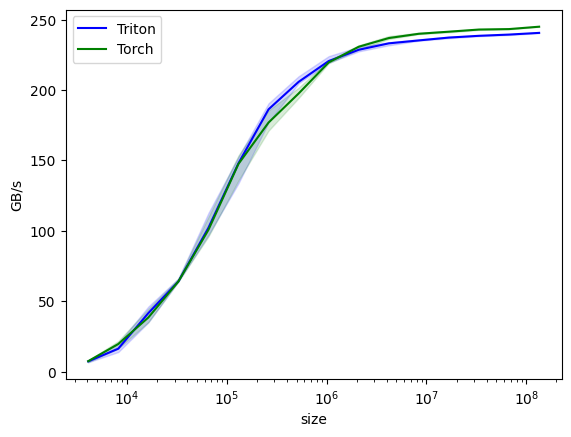

Vector Add Performance:
           size      Triton       Torch
0        4096.0    7.211267    7.384615
1        8192.0   16.253967   19.566879
2       16384.0   41.513516   38.400001
3       32768.0   63.999998   63.999998
4       65536.0  102.187111  100.721313
5      131072.0  148.048195  147.603602
6      262144.0  186.358294  176.964903
7      524288.0  205.872252  197.595978
8     1048576.0  220.659939  219.673742
9     2097152.0  228.680423  230.828288
10    4194304.0  233.241491  237.002038
11    8388608.0  235.317769  240.049444
12   16777216.0  237.350742  241.533161
13   33554432.0  238.601945  243.056460
14   67108864.0  239.473806  243.378495
15  134217728.0  240.680787  245.070739


In [29]:
benchmark.run(show_plots=True, print_data=True)